In [1]:
%matplotlib inline
import sys
import torch
import argparse
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import shutil

from torch.autograd import Variable
from torch.utils import data
import os

from dataset import IC15Loader
from metrics import runningScore
import models
from util import Logger, AverageMeter
import time
import util


In [2]:
def ohem_single(score, gt_text, training_mask):
    '''
    score: 모델이 text영역이라고 predict한 gray 이미지
    gt_text: 텍스트 영역을 1로 배경 영역을 0 으로 마킹한 바이너리 이미지.
    training_mask: don't care 영역을 0 으로 마킹한 바이너리 이미지
    '''
    print('in ohem_single. trainning_mask', training_mask.shape, '[0,0]=', training_mask[0,0])
    print('in ohem_single. gt_text', gt_text.shape, '[0,0]=', training_mask[0,0])
    
    # pos_num = 텍스트 영역 픽셀 갯수 - (텍스트 영역과 don't care 영역의 교집합 픽셀 갯수)
    #         = 유의미한 텍스트 영역 픽셀 갯수
    pos_num = (int)(np.sum(gt_text > 0.5)) - (int)(np.sum((gt_text > 0.5) & (training_mask <= 0.5)))
    print('in ohem_single. pos_num', pos_num)
    
    if pos_num == 0: # 유의미한 텍스트 영역이 없음. 
        # selected_mask = gt_text.copy() * 0 # may be not good
        selected_mask = training_mask
        selected_mask = selected_mask.reshape(1, selected_mask.shape[0], selected_mask.shape[1]).astype('float32')
        return selected_mask
    
    # neg_num = 텍스트가 아닌 영역 (don't care는 텍스트 영역에 포함)
    neg_num = (int)(np.sum(gt_text <= 0.5))
    # neg_num =  min(유의미한 텍스트 영역 픽셀 갯수 *3 , 텍스트가 아닌 영역 픽셀 갯수)
    neg_num = (int)(min(pos_num * 3, neg_num))
    
    print('in ohem_single. neg_num', neg_num)
    if neg_num == 0: # 모두다 텍스트 영역(don't care 도 텍스트에 포함) 
        selected_mask = training_mask
        selected_mask = selected_mask.reshape(1, selected_mask.shape[0], selected_mask.shape[1]).astype('float32')
        return selected_mask

    neg_score = score[gt_text <= 0.5] # 예측한 부분 중에 배경 부분만 골라냄
    neg_score_sorted = np.sort(-neg_score) # 배경인데 텍스트로 예측한 부분을 뒤로 몰아 넣음
    threshold = -neg_score_sorted[neg_num - 1]

    selected_mask = ((score >= threshold) | (gt_text > 0.5)) & (training_mask > 0.5)
    selected_mask = selected_mask.reshape(1, selected_mask.shape[0], selected_mask.shape[1]).astype('float32')
    
    print('in ohem_single. selected_mask', selected_mask.shape)
    return selected_mask


In [3]:
def ohem_batch(scores, gt_texts, training_masks):
    print('in ohem_batch. trainning_mask', training_masks.shape)
    print('in ohem_batch. gt_text', gt_texts.shape)
    scores = scores.data.cpu().numpy()
    gt_texts = gt_texts.data.cpu().numpy()
    training_masks = training_masks.data.cpu().numpy()
    selected_masks = []
    for i in range(scores.shape[0]):
        selected_masks.append(ohem_single(scores[i, :, :], gt_texts[i, :, :], training_masks[i, :, :]))
    selected_masks = np.concatenate(selected_masks, 0)
    selected_masks = torch.from_numpy(selected_masks).float()
    print('in ohem_batch. selected_mask', selected_masks.shape)
    return selected_masks

In [4]:
def dice_loss(input, target, mask):
    input = torch.sigmoid(input)

    input = input.contiguous().view(input.size()[0], -1)
    target = target.contiguous().view(target.size()[0], -1)
    mask = mask.contiguous().view(mask.size()[0], -1)
    
    input = input * mask
    target = target * mask

    a = torch.sum(input * target, 1)
    b = torch.sum(input * input, 1) + 0.001
    c = torch.sum(target * target, 1) + 0.001
    d = (2 * a) / (b + c)
    dice_loss = torch.mean(d)
    return 1 - dice_loss


In [5]:
def cal_text_score(texts, gt_texts, training_masks, running_metric_text):
    training_masks = training_masks.data.cpu().numpy()
    pred_text = torch.sigmoid(texts).data.cpu().numpy() * training_masks
    pred_text[pred_text <= 0.5] = 0
    pred_text[pred_text >  0.5] = 1
    pred_text = pred_text.astype(np.int32)
    gt_text = gt_texts.data.cpu().numpy() * training_masks
    gt_text = gt_text.astype(np.int32)
    running_metric_text.update(gt_text, pred_text)
    score_text, _ = running_metric_text.get_scores()
    return score_text

In [6]:
def cal_kernel_score(kernels, gt_kernels, gt_texts, training_masks, running_metric_kernel):
    mask = (gt_texts * training_masks).data.cpu().numpy()
    kernel = kernels[:, -1, :, :]
    gt_kernel = gt_kernels[:, -1, :, :]
    pred_kernel = torch.sigmoid(kernel).data.cpu().numpy()
    pred_kernel[pred_kernel <= 0.5] = 0
    pred_kernel[pred_kernel >  0.5] = 1
    pred_kernel = (pred_kernel * mask).astype(np.int32)
    gt_kernel = gt_kernel.data.cpu().numpy()
    gt_kernel = (gt_kernel * mask).astype(np.int32)
    running_metric_kernel.update(gt_kernel, pred_kernel)
    score_kernel, _ = running_metric_kernel.get_scores()
    return score_kernel

In [7]:
import matplotlib.pyplot as plt
def show_np_img(imgs, title = None):
    title = 'show_np_img() ' + (title or '')
    print(title,  imgs.shape)
    for img in imgs:
        if img.ndim > 2:
            show_np_img(img)
            continue
        print(title, 'img.shpae:', img.shape, 'imgs.shape:', imgs.shape)
        plt.imshow(img, cmap='gray') 
        plt.show()

In [70]:
import random
label_true = np.array([0,0,0,1,1,1,0,0,2,2])
label_pred = np.array([0,1,0,1,0,1,0,1,2,1])
print(label_true*3)
print(label_pred)
print(label_true*3 + label_pred)

b =np.bincount(label_true*3 + label_pred, minlength=9).reshape((3,3))
b

[0 0 0 3 3 3 0 0 6 6]
[0 1 0 1 0 1 0 1 2 1]
[0 1 0 4 3 4 0 1 8 7]


array([[3, 2, 0],
       [1, 2, 0],
       [0, 1, 1]])

In [20]:
from tqdm import tqdm_notebook as tqdm
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    running_metric_text = runningScore(2)
    running_metric_kernel = runningScore(2)

    end = time.time()
    for batch_idx, (imgs, gt_texts, gt_kernels, training_masks) in enumerate(tqdm(train_loader)):
        data_time.update(time.time() - end)
        
        imgs = Variable(imgs.cuda())
        gt_texts = Variable(gt_texts.cuda())
        gt_kernels = Variable(gt_kernels.cuda())
        training_masks = Variable(training_masks.cuda())

        outputs = model(imgs)
        print('\n', '===' * 10, '\noutputs:', outputs.shape)
        show_np_img(outputs.cpu().detach().numpy(), 'outputs')
        
        texts   = outputs[:, 0, :, :]
        
        kernels = outputs[:, 1:, :, :]
        
        selected_masks = ohem_batch(texts, gt_texts, training_masks)
        selected_masks = Variable(selected_masks.cuda())

        print('\n', '===' * 10, '\ntraining_masks:', training_masks.shape)
        show_np_img(training_masks.cpu().detach().numpy(), 'trainning_masks')
        print('\n', '===' * 10, '\nselected_masks:', selected_masks.shape)
        show_np_img(selected_masks.cpu().detach().numpy(), 'selected_masks')
        
        loss_text = criterion(texts, gt_texts, selected_masks)
        
        loss_kernels = []
        mask0 = torch.sigmoid(texts).data.cpu().numpy()
        mask1 = training_masks.data.cpu().numpy()
        selected_masks = ((mask0 > 0.5) & (mask1 > 0.5)).astype('float32')
        selected_masks = torch.from_numpy(selected_masks).float()
        selected_masks = Variable(selected_masks.cuda())
        for i in range(6):
            kernel_i = kernels[:, i, :, :]
            gt_kernel_i = gt_kernels[:, i, :, :]
            loss_kernel_i = criterion(kernel_i, gt_kernel_i, selected_masks)
            loss_kernels.append(loss_kernel_i)
        loss_kernel = sum(loss_kernels) / len(loss_kernels)
        
        loss = 0.7 * loss_text + 0.3 * loss_kernel
        losses.update(loss.item(), imgs.size(0))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        score_text = cal_text_score(texts, gt_texts, training_masks, running_metric_text)
        score_kernel = cal_kernel_score(kernels, gt_kernels, gt_texts, training_masks, running_metric_kernel)

        batch_time.update(time.time() - end)
        end = time.time()

        if batch_idx % 200 == 0:
            output_log  = '({batch}/{size}) Batch: {bt:.3f}s | TOTAL: {total:.0f}min | ETA: {eta:.0f}min | Loss: {loss:.4f} | Acc_t: {acc: .4f} | IOU_t: {iou_t: .4f} | IOU_k: {iou_k: .4f}'.format(
                batch=batch_idx + 1,
                size=len(train_loader),
                bt=batch_time.avg,
                total=batch_time.avg * batch_idx / 60.0,
                eta=batch_time.avg * (len(train_loader) - batch_idx) / 60.0,
                loss=losses.avg,
                acc=score_text['Mean Acc'],
                iou_t=score_text['Mean IoU'],
                iou_k=score_kernel['Mean IoU'])
            print(output_log)
            sys.stdout.flush()
        break

    return (losses.avg, score_text['Mean Acc'], score_kernel['Mean Acc'], score_text['Mean IoU'], score_kernel['Mean IoU'])


In [21]:
def adjust_learning_rate(args, optimizer, epoch):
    global state
    if epoch in args.schedule:
        args.lr = args.lr * 0.1
        for param_group in optimizer.param_groups:
            param_group['lr'] = args.lr

def save_checkpoint(state, checkpoint='checkpoint', filename='checkpoint.pth.tar'):
    filepath = os.path.join(checkpoint, filename)
    torch.save(state, filepath)

In [22]:
def main(args):
    if args.checkpoint == '':
        args.checkpoint = "checkpoints/ic15_%s_bs_%d_ep_%d"%(args.arch, args.batch_size, args.n_epoch)
    if args.pretrain:
        if 'synth' in args.pretrain:
            args.checkpoint += "_pretrain_synth"
        else:
            args.checkpoint += "_pretrain_ic17"

    print(('checkpoint path: %s'%args.checkpoint))
    print(('init lr: %.8f'%args.lr))
    print(('schedule: ', args.schedule))
    sys.stdout.flush()

    if not os.path.isdir(args.checkpoint):
        os.makedirs(args.checkpoint)

    kernel_num = 7
    min_scale = 0.4
    start_epoch = 0

    data_loader = IC15Loader(is_transform=True, img_size=args.img_size, kernel_num=kernel_num, min_scale=min_scale)
    train_loader = torch.utils.data.DataLoader(
        data_loader,
        batch_size=args.batch_size,
        shuffle=True,
        num_workers=12,
        drop_last=True,
        pin_memory=True)

    if args.arch == "resnet50":
        model = models.resnet50(pretrained=True, num_classes=kernel_num)
    elif args.arch == "resnet101":
        model = models.resnet101(pretrained=True, num_classes=kernel_num)
    elif args.arch == "resnet152":
        model = models.resnet152(pretrained=True, num_classes=kernel_num)
    
    model = torch.nn.DataParallel(model).cuda()
    
    if hasattr(model.module, 'optimizer'):
        optimizer = model.module.optimizer
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=args.lr, momentum=0.99, weight_decay=5e-4)

    title = 'icdar2015'
    if args.pretrain:
        print('Using pretrained model.')
        assert os.path.isfile(args.pretrain), 'Error: no checkpoint directory found!'
        checkpoint = torch.load(args.pretrain)
        model.load_state_dict(checkpoint['state_dict'])
        logger = Logger(os.path.join(args.checkpoint, 'log.txt'), title=title)
        logger.set_names(['Learning Rate', 'Train Loss','Train Acc.', 'Train IOU.'])
    elif args.resume:
        print('Resuming from checkpoint.')
        assert os.path.isfile(args.resume), 'Error: no checkpoint directory found!'
        checkpoint = torch.load(args.resume)
        start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        logger = Logger(os.path.join(args.checkpoint, 'log.txt'), title=title, resume=True)
    else:
        print('Training from scratch.')
        logger = Logger(os.path.join(args.checkpoint, 'log.txt'), title=title)
        logger.set_names(['Learning Rate', 'Train Loss','Train Acc.', 'Train IOU.'])

    for epoch in range(start_epoch, args.n_epoch):
        adjust_learning_rate(args, optimizer, epoch)
        print(('\nEpoch: [%d | %d] LR: %f' % (epoch + 1, args.n_epoch, optimizer.param_groups[0]['lr'])))

        train_loss, train_te_acc, train_ke_acc, train_te_iou, train_ke_iou = train(train_loader, model, dice_loss, optimizer, epoch)
        save_checkpoint({
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'lr': args.lr,
                'optimizer' : optimizer.state_dict(),
            }, checkpoint=args.checkpoint)

        logger.append([optimizer.param_groups[0]['lr'], train_loss, train_te_acc, train_te_iou])
        break
    logger.close()


checkpoint path: checkpoints/ic15_resnet50_bs_1_ep_600
init lr: 0.00100000
('schedule: ', [200, 400])
Resuming from checkpoint.

Epoch: [537 | 600] LR: 0.000010



outputs: torch.Size([1, 7, 640, 640])
show_np_img() outputs (1, 7, 640, 640)
show_np_img()  (7, 640, 640)
show_np_img()  img.shpae: (640, 640) imgs.shape: (7, 640, 640)


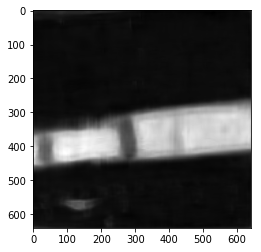

show_np_img()  img.shpae: (640, 640) imgs.shape: (7, 640, 640)


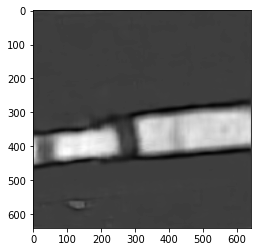

show_np_img()  img.shpae: (640, 640) imgs.shape: (7, 640, 640)


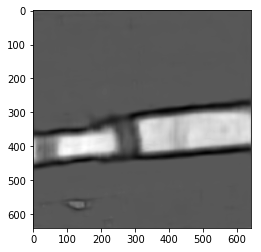

show_np_img()  img.shpae: (640, 640) imgs.shape: (7, 640, 640)


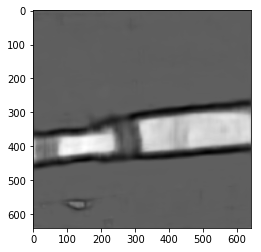

show_np_img()  img.shpae: (640, 640) imgs.shape: (7, 640, 640)


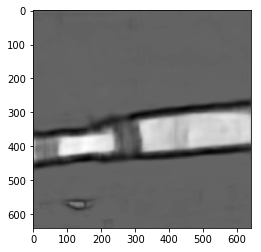

show_np_img()  img.shpae: (640, 640) imgs.shape: (7, 640, 640)


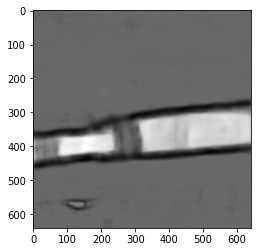

show_np_img()  img.shpae: (640, 640) imgs.shape: (7, 640, 640)


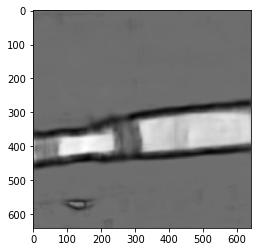


texts: torch.Size([1, 640, 640])
show_np_img() texts (1, 640, 640)
show_np_img() texts img.shpae: (640, 640) imgs.shape: (1, 640, 640)


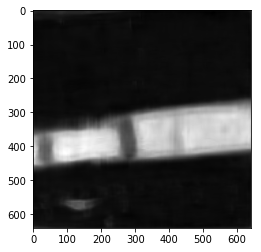


kernels: torch.Size([1, 6, 640, 640])
show_np_img() kernels (1, 6, 640, 640)
show_np_img()  (6, 640, 640)
show_np_img()  img.shpae: (640, 640) imgs.shape: (6, 640, 640)


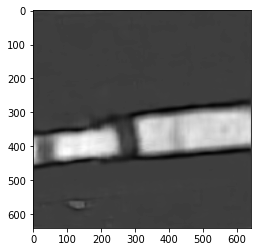

show_np_img()  img.shpae: (640, 640) imgs.shape: (6, 640, 640)


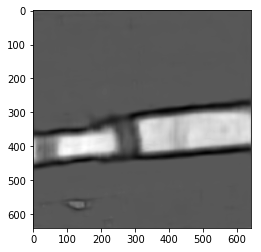

show_np_img()  img.shpae: (640, 640) imgs.shape: (6, 640, 640)


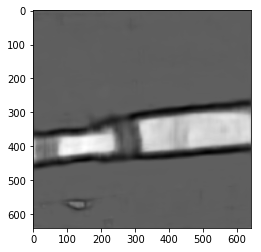

show_np_img()  img.shpae: (640, 640) imgs.shape: (6, 640, 640)


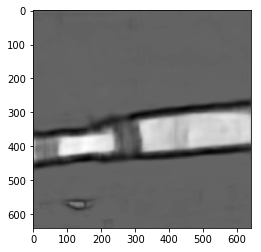

show_np_img()  img.shpae: (640, 640) imgs.shape: (6, 640, 640)


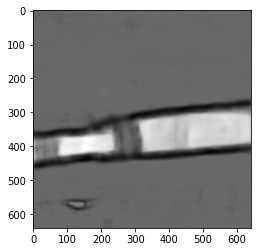

show_np_img()  img.shpae: (640, 640) imgs.shape: (6, 640, 640)


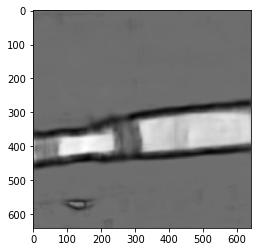

in ohem_batch. trainning_mask torch.Size([1, 640, 640])
in ohem_batch. gt_text torch.Size([1, 640, 640])
in ohem_single. trainning_mask (640, 640) [0,0]= 0.0
in ohem_single. gt_text (640, 640) [0,0]= 0.0
in ohem_single. pos_num 83777
in ohem_single. neg_num 251331
in ohem_single. selected_mask (1, 640, 640)
in ohem_batch. selected_mask torch.Size([1, 640, 640])

training_masks: torch.Size([1, 640, 640])
show_np_img() trainning_masks (1, 640, 640)
show_np_img() trainning_masks img.shpae: (640, 640) imgs.shape: (1, 640, 640)


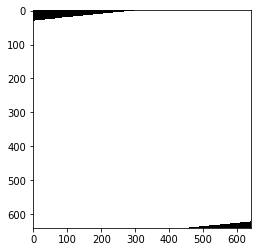


selected_masks: torch.Size([1, 640, 640])
show_np_img() selected_masks (1, 640, 640)
show_np_img() selected_masks img.shpae: (640, 640) imgs.shape: (1, 640, 640)


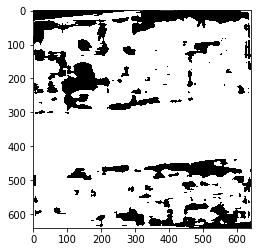

(1/10000) Batch: 4.136s | TOTAL: 0min | ETA: 689min | Loss: 0.0382 | Acc_t:  0.9626 | IOU_t:  0.9482 | IOU_k:  0.7548



In [26]:

def main_(): 
    parser = argparse.ArgumentParser(description='Hyperparams')
    parser.add_argument('--arch', nargs='?', type=str, default='resnet50')
    parser.add_argument('--img_size', nargs='?', type=int, default=640, 
                        help='Height of the input image')
    parser.add_argument('--n_epoch', nargs='?', type=int, default=600, 
                        help='# of the epochs')
    parser.add_argument('--schedule', type=int, nargs='+', default=[200, 400],
                        help='Decrease learning rate at these epochs.')
    parser.add_argument('--batch_size', nargs='?', type=int, default=1, 
                        help='Batch Size')
    parser.add_argument('--lr', nargs='?', type=float, default=1e-3, 
                        help='Learning Rate')
    parser.add_argument('--resume', nargs='?', type=str, default='./checkpoints/pse_net_checkpoint_538.pth.tar',    
                        help='Path to previous saved model to restart from')
    parser.add_argument('--pretrain', nargs='?', type=str, default=None,    
                        help='Path to previous saved model to restart from')
    parser.add_argument('--checkpoint', default='', type=str, metavar='PATH',
                    help='path to save checkpoint (default: checkpoint)')
    
    args = parser.parse_args('')

    main(args)

main_()

In [24]:
IPython.Cell.options_default.cm_config.lineNumbers = True;

NameError: name 'IPython' is not defined